In [20]:
import datetime as dt

import akshare as ak
import pandas as pd
# import pyecharts
import numpy as np
from scipy.signal import argrelextrema, find_peaks
import matplotlib
import matplotlib.pyplot as plt
import pyecharts.options as opts
from pyecharts.charts import Line, Scatter
from pyecharts.globals import ThemeType

from stockdatamanage.db import engine
from stockdatamanage.db.sqlrw import writeSQL

In [32]:
%matplotlib inline

In [10]:
df = ak.index_value_name_funddb() 
# df.head()
df.to_excel('d:/tmp/index_value_name_funddb.xlsx')

In [8]:
for index, row in df.iterrows():
    if '沪深' in row.指数名称:
        print(row.指数名称)

沪深300红利
沪深300周期
沪深300
沪深300非周期


In [13]:
df = ak.index_value_hist_funddb(symbol="上证180", indicator="市盈率")
# print(df[(df.日期>="20201101")&(df.日期<="20201130")])

In [17]:
start_date = dt.date(2020, 11, 1)
end_date = dt.date(2020, 11, 30)
print(df[(df.日期>=start_date)&(df.日期<=end_date)])

              日期    平均值    市盈率  最低30  最低10   最高30   最高10
1922  2020-11-02  10.72  12.19   NaN   NaN  12.19    NaN
1923  2020-11-03  10.72  12.34   NaN   NaN  12.34    NaN
1924  2020-11-04  10.72  12.38   NaN   NaN  12.38    NaN
1925  2020-11-05  10.72  12.51   NaN   NaN  12.51    NaN
1926  2020-11-06  10.72  12.51   NaN   NaN  12.51    NaN
1927  2020-11-09  10.72  12.72   NaN   NaN  12.72    NaN
1928  2020-11-10  10.72  12.71   NaN   NaN  12.71    NaN
1929  2020-11-11  10.72  12.70   NaN   NaN  12.70    NaN
1930  2020-11-12  10.72  12.64   NaN   NaN  12.64    NaN
1931  2020-11-13  10.72  12.47   NaN   NaN  12.47    NaN
1932  2020-11-16  10.72  12.60   NaN   NaN  12.60    NaN
1933  2020-11-17  10.72  12.61   NaN   NaN  12.61    NaN
1934  2020-11-18  10.72  12.67   NaN   NaN  12.67    NaN
1935  2020-11-19  10.72  12.74   NaN   NaN  12.74    NaN
1936  2020-11-20  10.72  12.76   NaN   NaN  12.76    NaN
1937  2020-11-23  10.72  12.93   NaN   NaN  12.93  12.93
1938  2020-11-24  10.72  12.86 

In [ ]:
df = ak.fund_open_fund_daily_em()
print(df)

In [ ]:
a = [name for name in df.基金简称 if '300ETF' in name]
print(a)

In [2]:
df = ak.index_zh_a_hist(symbol="399300", period="daily", start_date="20210618", end_date="20210630")
print(df)

In [20]:
df.columns

Index(['日期', '开盘', '收盘', '最高', '最低', '成交量', '成交额', '振幅', '涨跌幅', '涨跌额', '换手率'], dtype='object')

In [7]:
sql = 'SELECT code, max(trade_date) update_date FROM index_daily group by code;'
updatedf = pd.read_sql(sql, engine)

In [8]:
updatedf.head()

,code,update_date
0,000001,2021-06-18
1,000005,2021-06-18
2,000006,2021-06-18
3,000010,2021-06-18
4,000016,2021-06-18


In [18]:
for index, row in updatedf.iterrows():
    print(row['code'], row['update_date'])
    # print(row)
    # print(type(row))

000001 2021-06-18
000005 2021-06-18
000006 2021-06-18
000010 2021-06-18
000016 2021-06-18
000905 2021-06-18
399001 2021-06-18
399005 2021-06-18
399006 2021-06-18
399016 2021-06-18
399300 2021-06-18


In [55]:
index_dict = {'上证指数': '000001.SH',
'上证380': '000009.SH',
'上证180': '000010.SH',
'上证50': '000016.SH',
'科创50': '000688.SH',
'中证1000': '000852.SH',
'中证100': '000903.SH',
'中证500': '000905.SH',
'深证成指': '399001.SZ',
'创业板指': '399006.SZ',
'创业板50': '399673.SZ',
'证券公司': '399975.SZ',
}
indicators = ['市盈率', '市净率', '股息率']

# 当前时间减18小时得到需更新的日期，即0点至18点仅更新至前一日数据
end_date = dt.datetime.today() - dt.timedelta(hours=18)
end_date = end_date.date()

for index_name in index_dict.keys():
    index_code = index_dict[index_name]
    # print(index_name, index_code)
    
    sql = f'select max(trade_date) from index_dailyindicator where code="{index_code}"'
    res = engine.execute(sql).fetchone()[0]
    # print(res)
    if res:
        start_date = res
    else:
        start_date = dt.date(1980, 1, 1)
    print(index_code, start_date, end_date)
    # df = pd.DataFrame({'code':[], 'trade_date': [], 'pe':[], 'pb':[], 'dv': []})
    dfpe = ak.index_value_hist_funddb(symbol=index_name, indicator="市盈率")
    dfpe = dfpe.loc[(dfpe.日期>=start_date)&(dfpe.日期<=end_date), ['日期', '市盈率']]
    dfpb = ak.index_value_hist_funddb(symbol=index_name, indicator="市净率")
    dfpb = dfpb[['日期', '市净率']]
    dfdv = ak.index_value_hist_funddb(symbol=index_name, indicator="股息率")
    dfdv = dfdv[['日期', '股息率']]
    # print(dfpe.head())
    # print(dfpb.head())
    # print(dfdv.head())

    df = dfpe.merge(dfpb, how='left', on='日期')
    df = df.merge(dfdv, how='left', on='日期')
    df.rename(columns={'日期': 'trade_date', 
            '市盈率': 'pe',
            '市净率': 'pb',
            '股息率': 'dv',
    }, inplace=True)
    df['code'] = index_code
    # print(df.head())
    writeSQL(df, 'index_dailyindicator')
    



000001.SH 2022-11-15 2022-11-15
000009.SH 1980-01-01 2022-11-15
000010.SH 1980-01-01 2022-11-15
000016.SH 1980-01-01 2022-11-15
000688.SH 1980-01-01 2022-11-15
000852.SH 1980-01-01 2022-11-15
000903.SH 1980-01-01 2022-11-15
000905.SH 1980-01-01 2022-11-15
399001.SZ 1980-01-01 2022-11-15
399006.SZ 1980-01-01 2022-11-15
399673.SZ 1980-01-01 2022-11-15
399975.SZ 1980-01-01 2022-11-15


In [51]:
df = dfpe.merge(dfpb, how='left', on='日期')
df = df.merge(dfdv, how='left', on='日期')
df.rename(columns={'日期': 'trade_date', 
        '市盈率': 'pe',
        '市净率': 'pb',
        '股息率': 'dv',
}, inplace=True)
# df['code'] = index_code
df.head()

,trade_date,pe,pb,dv
0,2012-11-15,10.47,1.43,2.78
1,2012-11-16,10.40,1.42,2.81
2,2012-11-19,10.41,1.42,2.80
3,2012-11-20,10.36,1.42,2.81
4,2012-11-21,10.47,1.43,2.78


In [45]:
# end_date = dt.datetime.today() - dt.timedelta(hours=18)
# end_date = end_date.date()
# end_date
dfpe.loc[(df.日期>=start_date)&(df.日期<=end_date), ['日期', '市盈率']]

,日期,市盈率
0,2012-11-15,10.47
1,2012-11-16,10.40
2,2012-11-19,10.41
3,2012-11-20,10.36
4,2012-11-21,10.47
...,...,...
2422,2022-11-09,11.94
2423,2022-11-10,11.90
2424,2022-11-11,12.10
2425,2022-11-14,12.10


In [27]:
df = pd.DataFrame({'code':[], 'trade_date': [], 'pe':[], 'pb':[], 'dv': []})
print(df)

Empty DataFrame
Columns: [code, trade_date, pe, pb, dv]
Index: []


In [56]:
df = ak.fund_etf_fund_daily_em()
print(df)

       基金代码                  基金简称      类型 2022-11-16-单位净值 2022-11-16-累计净值  \
0    511010        国泰上证5年期国债ETF行情  债券型-长债        128.5260          1.2980   
1    511260       国泰上证10年期国债ETF行情  债券型-长债        118.8580          1.1890   
2    511310       富国中证10年期国债ETF行情  债券型-长债        117.5952          1.1760   
3    159972         鹏华中证5年地债ETF行情  债券型-长债        112.3854          1.1261   
4    511270        海富通上证10年期ETF行情  债券型-长债        108.8687          1.2094   
..      ...                   ...     ...             ...             ...   
716  159627          华夏中证100ETF行情  指数型-股票             ---             ---   
717  159655    华夏标普500ETF(QDII)行情    QDII             ---             ---   
718  511580   招商中证政策性金融债3-5年ETF行情  债券型-长债             ---             ---   
719  513310  华泰柏瑞中韩半导体ETF(QDII)行情    QDII             ---             ---   
720  561710      博时中证疫苗与生物技术ETF行情  指数型-股票             ---             ---   

    2022-11-15-单位净值 2022-11-15-累计净值      增长值     增长率        市价    折价率  
0  

In [61]:
df = ak.fund_etf_fund_info_em(fund="510300", start_date="20000101")
# df = ak.fund_etf_fund_info_em(fund="511280", start_date="20000101", end_date="20500101")
print(df)

            净值日期    单位净值    累计净值  日增长率  申购状态  赎回状态
0     2012-05-04  1.0070  1.0070   NaN  场内买入  场内卖出
1     2012-05-11  2.6370  0.9780 -2.86  场内买入  场内卖出
2     2012-05-18  2.5740  0.9550 -2.39  场内买入  场内卖出
3     2012-05-21  2.5880  0.9600  0.54  场内买入  场内卖出
4     2012-05-25  2.5740  0.9550 -0.54  场内买入  场内卖出
...          ...     ...     ...   ...   ...   ...
2556  2022-11-10  3.7483  1.5893 -0.76  场内买入  场内卖出
2557  2022-11-11  3.8518  1.6277  2.76  场内买入  场内卖出
2558  2022-11-14  3.8567  1.6295  0.13  场内买入  场内卖出
2559  2022-11-15  3.9279  1.6559  1.85  场内买入  场内卖出
2560  2022-11-16  3.8961  1.6441 -0.81  场内买入  场内卖出

[2561 rows x 6 columns]


In [84]:
df['quantile'] = df['单位净值'].rolling(window=6).apply(cal)
df

,净值日期,单位净值,累计净值,日增长率,申购状态,赎回状态,rolling,quantile
0,2012-05-04,1.007,1.007,NaN,场内买入,场内卖出,NaN,NaN
1,2012-05-11,2.637,0.978,-2.86,场内买入,场内卖出,NaN,NaN
2,2012-05-18,2.574,0.955,-2.39,场内买入,场内卖出,NaN,NaN
3,2012-05-21,2.588,0.960,0.54,场内买入,场内卖出,NaN,NaN
4,2012-05-25,2.574,0.955,-0.54,场内买入,场内卖出,11.380,NaN
5,2012-05-28,2.615,0.970,1.59,场内买入,场内卖出,12.988,83.0
6,2012-05-29,2.652,0.984,1.41,场内买入,场内卖出,13.003,100.0
7,2012-05-30,2.643,0.980,-0.34,场内买入,场内卖出,13.072,83.0
8,2012-05-31,2.635,0.977,-0.30,场内买入,场内卖出,13.119,66.0
9,2012-06-01,2.636,0.978,0.04,场内买入,场内卖出,13.181,66.0


In [75]:
df

,净值日期,单位净值,累计净值,日增长率,申购状态,赎回状态,rolling
0,2012-05-04,1.007,1.007,NaN,场内买入,场内卖出,NaN
1,2012-05-11,2.637,0.978,-2.86,场内买入,场内卖出,NaN
2,2012-05-18,2.574,0.955,-2.39,场内买入,场内卖出,NaN
3,2012-05-21,2.588,0.960,0.54,场内买入,场内卖出,NaN
4,2012-05-25,2.574,0.955,-0.54,场内买入,场内卖出,11.380
5,2012-05-28,2.615,0.970,1.59,场内买入,场内卖出,12.988
6,2012-05-29,2.652,0.984,1.41,场内买入,场内卖出,13.003
7,2012-05-30,2.643,0.980,-0.34,场内买入,场内卖出,13.072
8,2012-05-31,2.635,0.977,-0.30,场内买入,场内卖出,13.119
9,2012-06-01,2.636,0.978,0.04,场内买入,场内卖出,13.181


In [73]:
df = df[:20]

In [83]:
def cal(x):
    return int(len(x[x<=x.iloc[-1]]) / len(x) * 100)

In [68]:
df.to_excel('d:/tmp/rolling.xlsx')

In [2]:
sql = 'select trade_date, close from index_daily where code="399300";'
index_df = pd.read_sql(sql, engine)
index_df.head()

,trade_date,close
0,2005-01-04,982.794
1,2005-01-05,992.564
2,2005-01-06,983.174
3,2005-01-07,983.958
4,2005-01-10,993.879


In [3]:
sql = 'select trade_date, pe from index_dailyindicator where code="399300.SZ";'
indexpe_df = pd.read_sql(sql, engine)
indexpe_df.head()

,trade_date,pe
0,2012-11-21,9.77
1,2012-11-22,9.71
2,2012-11-23,9.76
3,2012-11-26,9.71
4,2012-11-27,9.64


In [4]:
df = index_df.merge(indexpe_df, how='inner', on='trade_date')
df.head()


,trade_date,close,pe
0,2012-11-21,2194.90,9.77
1,2012-11-22,2177.55,9.71
2,2012-11-23,2192.68,9.76
3,2012-11-26,2175.60,9.71
4,2012-11-27,2150.64,9.64


In [6]:
df['c_p'] = df.close / df.pe
df.head()

,trade_date,close,pe,c_p
0,2012-11-21,2194.90,9.77,224.657114
1,2012-11-22,2177.55,9.71,224.258496
2,2012-11-23,2192.68,9.76,224.659836
3,2012-11-26,2175.60,9.71,224.057673
4,2012-11-27,2150.64,9.64,223.095436


In [27]:
# df.round(1)
# df['c_p'] = df.c_p.round(1)
df

,trade_date,close,pe,c_p
0,2012-11-21,2194.90,9.77,224.7
1,2012-11-22,2177.55,9.71,224.3
2,2012-11-23,2192.68,9.76,224.7
3,2012-11-26,2175.60,9.71,224.1
4,2012-11-27,2150.64,9.64,223.1
...,...,...,...,...
2419,2022-11-08,3749.33,10.88,344.6
2420,2022-11-09,3714.27,10.79,344.2
2421,2022-11-10,3685.69,10.74,343.2
2422,2022-11-11,3788.44,11.00,344.4


In [36]:
df.to_excel('d:/tmp/hs300.xlsx')

In [21]:
line = Line(init_opts=opts.InitOpts(width='800px', height='400px',theme=ThemeType.DARK))
line.add_xaxis(xaxis_data=df.trade_date.to_list())
# line.add_yaxis('close', y_axis=df.close.to_list())
line.add_yaxis('pe', y_axis=df.pe.to_list())
# line.add_yaxis('c_p', y_axis=df.c_p.to_list())

scatter_max = Scatter(init_opts=opts.InitOpts(width='800px', height='400px'))
x_max = [df.trade_date[i] for i in peaks_max]
y_max = [df.pe[i] for i in peaks_max]
scatter_max.add_xaxis(xaxis_data=x_max)
scatter_max.add_yaxis('max', y_axis=y_max)

scatter_min = Scatter(init_opts=opts.InitOpts(width='800px', height='400px'))
x_min = [df.trade_date[i] for i in peaks_min]
y_min = [df.pe[i] for i in peaks_min]
scatter_min.add_xaxis(xaxis_data=x_min)
scatter_min.add_yaxis('min', y_axis=y_min)

line.overlap(scatter_max)
line.overlap(scatter_min)
# line.overlap(scatter)

line.set_global_opts(
        xaxis_opts=opts.AxisOpts(is_scale=True),
        yaxis_opts=opts.AxisOpts(
            is_scale=True,
            splitarea_opts=opts.SplitAreaOpts(
                is_show=True, areastyle_opts=opts.AreaStyleOpts(opacity=1)
            ),
        ),
        datazoom_opts=[opts.DataZoomOpts(pos_bottom="-2%")],
        title_opts=opts.TitleOpts(title="指数PE"),
    )
line.render_notebook()

TypeError: set_global_opts() got an unexpected keyword argument 'theme'

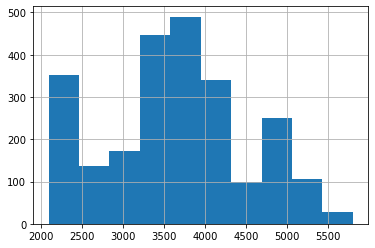

In [33]:
df.close.hist()
plt.show()

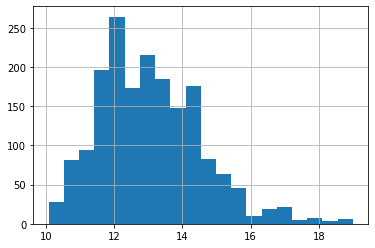

In [37]:
df.pe[600:].hist(bins=20)
plt.show()

In [13]:
peaks_max = argrelextrema(df.pe.values, np.greater_equal, order=200)[0]
peaks_min = argrelextrema(df.pe.values, np.less_equal, order=200)[0]
# peaks_max = peaks[0]
print(peaks_max)
print(peaks_min)
# plt.plot(df.pe)
# plt.plot(peaks, x[peaks], "o")
# plt.title("scipy.signal.argrelextrema")
# plt.show() 

[  52  614 1259 1557 2000]
[ 356  773 1486 1487 1781 2413]


In [39]:
peaks_min, _ = find_peaks(df.pe.values, distance=200)
print(peaks_min)
print(df.iloc[peaks_min])

[  52  255  614  975 1259 1557 1769 2000 2201 2402]
      trade_date    close     pe         c_p
52    2013-02-06  2775.84  11.74  236.442930
255   2013-12-16  2367.92   9.10  260.210989
614   2015-06-08  5353.75  19.00  281.776316
975   2016-11-29  3564.04  13.77  258.826434
1259  2018-01-24  4389.89  15.78  278.193283
1557  2019-04-19  4120.61  13.48  305.683234
1769  2020-03-05  4206.73  12.51  336.269384
2000  2021-02-10  5807.72  17.44  333.011468
2201  2021-12-13  5083.80  14.37  353.778706
2402  2022-10-14  3842.47  11.25  341.552889


In [9]:
a = np.array(df.pe)
print(a)

[ 9.77  9.71  9.76 ... 10.74 11.   11.  ]


In [7]:
dftmp = df.iloc[1100:1600]
dftmp

,trade_date,close,pe
1100,2017-06-07,3533.87,13.29
1101,2017-06-08,3560.98,13.36
1102,2017-06-09,3576.17,13.41
1103,2017-06-12,3574.39,13.52
1104,2017-06-13,3582.27,13.54
...,...,...,...
1595,2019-06-18,3667.62,12.02
1596,2019-06-19,3715.94,12.14
1597,2019-06-20,3828.52,12.47
1598,2019-06-21,3833.94,12.48


In [10]:
pemin = dftmp.pe.min()

In [12]:
for i in range(len(dftmp.pe)):
    if dftmp.iloc[i].pe == pemin:
        print(dftmp.iloc[i])

trade_date    2019-01-02
close            2969.54
pe                 10.08
Name: 1486, dtype: object
trade_date    2019-01-03
close            2964.84
pe                 10.08
Name: 1487, dtype: object
